In [ ]:
!pip install matplotlib keras tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzipping and renaming file

In [ ]:
import os

# Set the path to your dataset.zip file
zip_path = '/content/drive/MyDrive/Final_dataset.rar'

# Set the output directory where the files will be extracted
output_dir = '/content/'

# Make sure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Unzip the file
!unrar x -o+ "$zip_path" "$output_dir"

# renaming to data
# set
current_folder_path = '/content/Final_dataset'

# Desired new folder name
new_folder_path = '/content/data'

# Rename the folder
os.rename(current_folder_path, new_folder_path)


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/Final_dataset.rar

Creating    /content/Final_dataset                                    OK
Creating    /content/Final_dataset/1                                  OK
Creating    /content/Final_dataset/1/test                             OK
Creating    /content/Final_dataset/1/test/Forgery                     OK
Extracting  /content/Final_dataset/1/test/Forgery/102_r.tif                0%  OK 
Extracting  /content/Final_dataset/1/test/Forgery/104_r.tif                0%  OK 
Extracting  /content/Final_dataset/1/test/Forgery/115_r.tif                0%  OK 
Extracting  /content/Final_dataset/1/test/Forgery/14_et.tif                0%  OK 
Extracting  /content/Final_dataset/1/test/Forgery/14_gd.tif                0%  OK 
Extracting  /content/Final_dataset/1/test/Forgery/15_et.tif                0%  OK 
Extracting  /content/F

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Multiply, Reshape, SpatialDropout2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:

# Parameters
num_classes = 2  # Genuine, Forged
input_shape = (224, 224, 1)  # Change from (224, 224, 3) for grayscale images
batch_size = 16
epochs = 25

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=10000,
    decay_rate=0.9
)

## Residual Block

In [ ]:
def residual_block(x, filters):
    shortcut = x

    if x.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    return Activation('swish')(x)

## SE Block

In [ ]:
# Squeeze-and-Excitation (SE) Block
def se_block(x, ratio=16):
    channels = x.shape[-1]
    se = GlobalAveragePooling2D()(x)
    se = Dense(channels // ratio, activation='swish')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, 1, channels))(se)
    return Multiply()([x, se])

In [ ]:
def create_grayscale_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Stem (Initial Convolution)
    x = Conv2D(24, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)


    # Backbone (Feature Extraction)
    x = residual_block(x, 48)
    x = se_block(x)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block(x, 96)
    x = se_block(x)
    x = MaxPooling2D((2, 2))(x)

    # Head (Classification Layer)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='swish', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                      loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                      metrics=['accuracy'])
    return model

In [ ]:
# # Total parameters
# total_params = model.count_params()
# print(f"Total parameters: {total_params}")

# # Trainable parameters
# trainable_params = sum([K.count_params(w) for w in model.trainable_weights])
# print(f"Trainable parameters: {trainable_params}")

# # Non-trainable parameters
# non_trainable_params = sum([K.count_params(w) for w in model.non_trainable_weights])
# print(f"Non-trainable parameters: {non_trainable_params}")


In [ ]:
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D,
                                     GlobalAveragePooling2D, Dense, Dropout, Input, Add, Multiply, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
model=create_grayscale_cnn(input_shape, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │      1,200 │ input_layer_1[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         96 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 55, 55,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 55, 55,    │     10,416 │ max_pooling2d_3[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        192 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 55, 55,    │      1,200 │ max_pooling2d_3[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 55, 55,    │     20,784 │ activation_6[0][… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        192 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        192 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 55, 55,    │          0 │ batch_normalizat… │
│                     │ 48)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 55, 55,    │          0 │ add_2[0][0]       │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 48)        │          0 │ activation_7[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 3)         │        147 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 48)        │        192 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 191,675 (748.73 KB)

 Trainable params: 190,763 (745.17 KB)

 Non-trainable params: 912 (3.56 KB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Instantiate ImageDataGenerator without color_mode
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen   = ImageDataGenerator(rescale=1.0/255)
test_datagen  = ImageDataGenerator(rescale=1.0/255)

# Pass color_mode in flow_from_directory
train_generator = train_datagen.flow_from_directory(
    '/content/data/1/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'  # Specify grayscale here
)

val_generator = val_datagen.flow_from_directory(
    '/content/data/1/valid',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    '/content/data/1/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)


Found 198 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Found 31 images belonging to 2 classes.


In [ ]:
# # Callbacks
# checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping Callback
early_stop = EarlyStopping(
    monitor='val_loss',  # You can also use 'val_accuracy'
    patience=25,         # Number of epochs with no improvement before stopping
    restore_best_weights=True
)

# ModelCheckpoint to save best model
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train Model with EarlyStopping and Checkpoint
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint],
    initial_epoch=25
)


Epoch 26/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 698ms/step - accuracy: 0.7145 - loss: 0.6927 - val_accuracy: 0.7321 - val_loss: 0.6960
Epoch 27/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.7671 - loss: 0.6578 - val_accuracy: 0.7321 - val_loss: 0.6950
Epoch 28/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.7373 - loss: 0.6633 - val_accuracy: 0.7321 - val_loss: 0.6931
Epoch 29/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.7158 - loss: 0.6901 - val_accuracy: 0.7143 - val_loss: 0.6959
Epoch 30/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8351 - loss: 0.6297 - val_accuracy: 0.7321 - val_loss: 0.6947
Epoch 31/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.7886 - loss: 0.6444 - val_accuracy: 0.7500 - val_loss: 0.6945
Epoch 32/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7041 - loss: 0.7051 - val_accuracy: 0.7321 - val_loss: 0.6928
Epoch 33/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.7587 - loss: 0.6808 -

In [ ]:
# Evaluate Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8501 - loss: 0.4961
Test Accuracy: 80.65%


In [ ]:
model.save("WD1.keras")

# SAVING THE HISTORY OF COMPLETED TRAINING

In [ ]:
import json
import tensorflow as tf
# Create a directory for saving the history
os.makedirs('/content/training_logs', exist_ok=True)

# Save the history in that folder
with open('/content/training_logs/training_history.json', 'w') as f:
    json.dump(history.history, f)

print("Training history saved to /content/training_logs/training_history.json")


Training history saved to /content/training_logs/training_history.json


## OR

In [ ]:
import os
import pickle

# Create the directory to save the model history if it doesn't exist
os.makedirs('/content/saved_models', exist_ok=True)

# Save the training history with pickle
with open('/content/saved_models/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Training history saved to /content/saved_models/training_history.pkl")


Training history saved to /content/saved_models/training_history.pkl


# LOADING THE HISTORY

# EVALUATION PARTS

# loading the saved model ....

In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the HDF5 file
model = load_model('/content/best_model.keras')


# Verify the model has been loaded correctly
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │      1,200 │ input_layer_1[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         96 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 55, 55,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 55, 55,    │     10,416 │ max_pooling2d_3[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        192 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 55, 55,    │      1,200 │ max_pooling2d_3[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 55, 55,    │     20,784 │ activation_6[0][… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        192 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        192 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 55, 55,    │          0 │ batch_normalizat… │
│                     │ 48)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 55, 55,    │          0 │ add_2[0][0]       │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 48)        │          0 │ activation_7[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 3)         │        147 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 48)        │        192 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 573,202 (2.19 MB)

 Trainable params: 190,763 (745.17 KB)

 Non-trainable params: 912 (3.56 KB)

 Optimizer params: 381,527 (1.46 MB)

In [ ]:
model.compile(optimizer=None)  # This removes the optimizer state


In [ ]:
# Verify the model has been loaded correctly
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │      1,200 │ input_layer_1[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         96 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 55, 55,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 55, 55,    │     10,416 │ max_pooling2d_3[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        192 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 55, 55,    │      1,200 │ max_pooling2d_3[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 55, 55,    │     20,784 │ activation_6[0][… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        192 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        192 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 55, 55,    │          0 │ batch_normalizat… │
│                     │ 48)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 55, 55,    │          0 │ add_2[0][0]       │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 48)        │          0 │ activation_7[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 3)         │        147 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 48)        │        192 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 191,675 (748.73 KB)

 Trainable params: 190,763 (745.17 KB)

 Non-trainable params: 912 (3.56 KB)

In [ ]:
# Save the model without optimizer
model.save("mode_without_optimizer.keras", include_optimizer=False)

print("Model saved without optimizer parameters.")

Model saved without optimizer parameters.


#TRAIN/VAL LOSS GRAPH

In [ ]:
import pickle

# Load history from a pickle file
with open("/content/saved_models/training_history.pkl", "rb") as f:
    history = pickle.load(f)

print(history.keys())  # Check available keys (e.g., loss, val_loss, accuracy, etc.)


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [ ]:
import numpy as np

# Get validation loss and find the best epoch
val_loss = history["val_loss"]  # Or use "val_accuracy" if needed
best_epoch = np.argmin(val_loss) + 1  # +1 because epochs start from 1

print(f"Best epoch: {best_epoch}, with val_loss: {val_loss[best_epoch-1]}")


Best epoch: 174, with val_loss: 0.5476595163345337


In [ ]:
import numpy as np

# Get validation loss and find the best epoch
val_loss = history.history["val_loss"]  # Or use "val_accuracy" if needed
best_epoch = np.argmin(val_loss) + 1  # +1 because epochs start from 1

print(f"Best epoch: {best_epoch}, with val_loss: {val_loss[best_epoch-1]}")


AttributeError: 'dict' object has no attribute 'history'

In [ ]:
# Find last trained epoch
last_epoch = len(history["loss"])
print(f"{last_epoch}")

175


In [ ]:
import pickle

# Load history from a pickle file
with open("/content/okay.pkl", "rb") as f:
    loaded_history = pickle.load(f)

print(loaded_history.keys())  # Check available keys (e.g., loss, val_loss, accuracy, etc.)


FileNotFoundError: [Errno 2] No such file or directory: '/content/okay.pkl'

In [ ]:

combined_history = {key: loaded_history[key] + history.history[key] for key in history.history}

# Save the combined history
with open('/content/saved_models/combined_training_history.pkl', 'wb') as f:
    pickle.dump(combined_history, f)


AttributeError: 'dict' object has no attribute 'history'

In [ ]:
import pickle

# Load history from a pickle file
# with open("/content/saved_models/combined_training_history.pkl", "rb") as f:
with open("/content/saved_models/training_history.pkl", "rb") as f:
    loaded_history = pickle.load(f)

print(loaded_history.keys())  # Check available keys (e.g., loss, val_loss, accuracy, etc.)


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


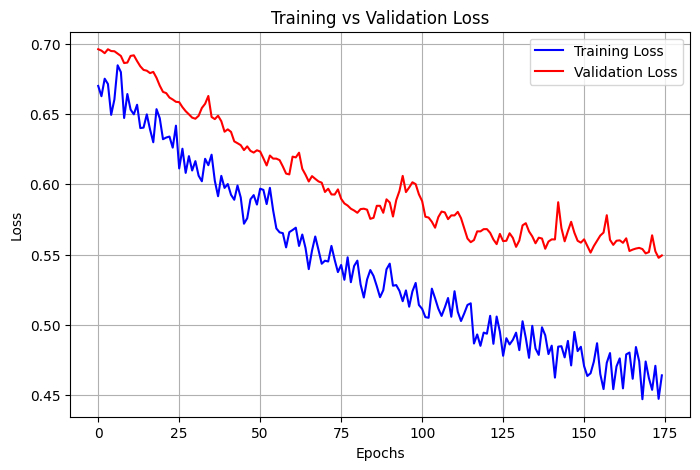

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and validation loss
train_loss = loaded_history["loss"]
val_loss = loaded_history["val_loss"]

# Plot the graph
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", color="blue")
plt.plot(val_loss, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Extract loss and validation loss
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Plot the graph
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", color="blue")
plt.plot(val_loss, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


AttributeError: 'dict' object has no attribute 'history'

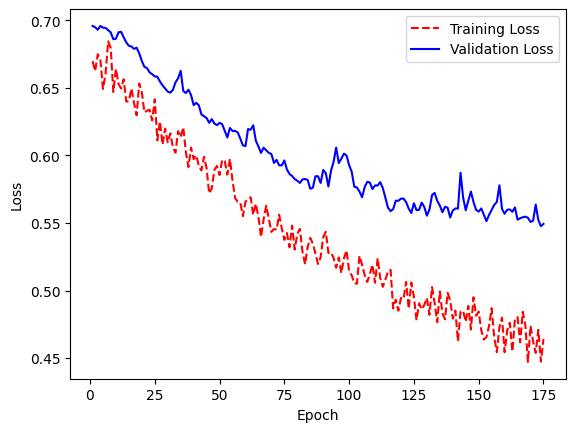

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable storing the training history
# (from model.fit)

# Get training and validation loss histories
training_loss = history['loss']
validation_loss = history['val_loss']

# Create count of the numbe|r of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

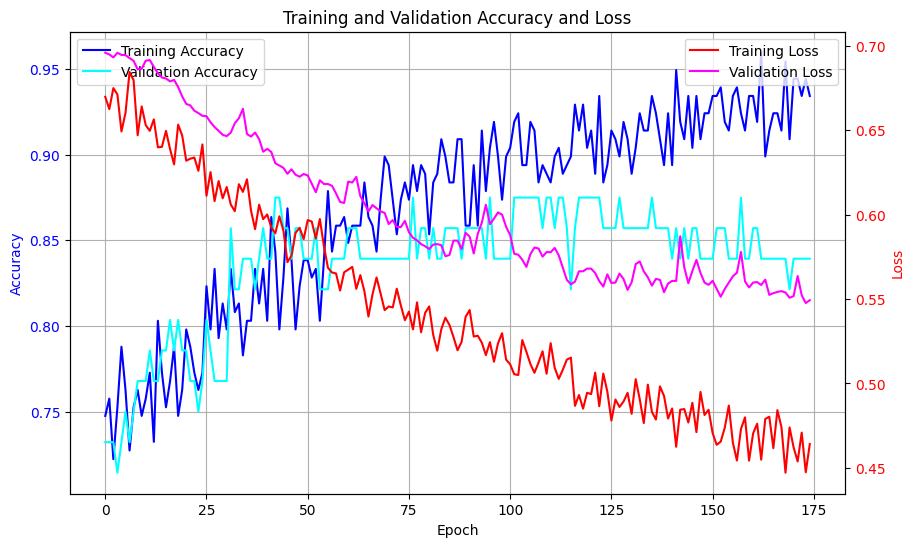

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#CONFUSION MATRIX


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


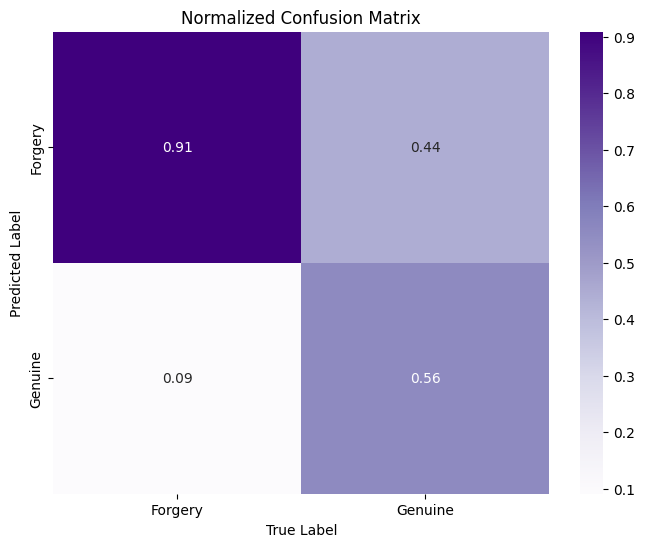

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get true labels
true_labels = test_generator.classes  # Extract true labels

# Get class names (to label the confusion matrix)
class_names = list(test_generator.class_indices.keys())

# Get predictions from model
pred_probs = model.predict(test_generator)  # Predict probabilities
pred_labels = np.argmax(pred_probs, axis=1) # Convert probabilities to class labels

# Compute confusion matrix
conf_matrix_s= confusion_matrix(true_labels, pred_labels)
conf_matrix=conf_matrix_s.transpose()


# Normalize by column (true class)
conf_matrix_norm_col = conf_matrix.astype("float") / conf_matrix.sum(axis=0, keepdims=True)  # Column-wise normalization

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm_col, annot=True, fmt=".2f", cmap="Purples", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("True Label")
plt.ylabel("Predicted Label")

plt.title("Normalized Confusion Matrix")
plt.show()



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


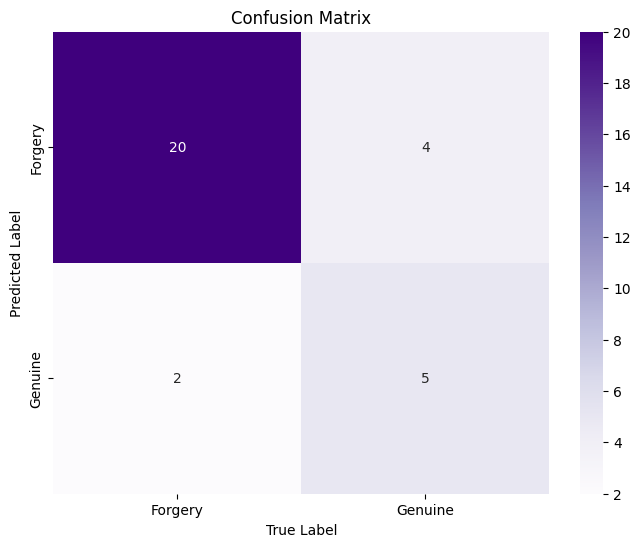

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get true labels
true_labels = test_generator.classes  # Extract true labels

# Get class names (to label the confusion matrix)
class_names = list(test_generator.class_indices.keys())

# Get predictions from model
pred_probs = model.predict(test_generator)  # Predict probabilities
pred_labels = np.argmax(pred_probs, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix and swap axes
conf_matrix = confusion_matrix(true_labels, pred_labels).T  # Transpose to swap X and Y

# Plot transposed confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("True Label")  # Now, True labels are on X-axis
plt.ylabel("Predicted Label")  # Predicted labels are on Y-axis
plt.title("Confusion Matrix")
plt.show()


#F1 CONFIDENCE

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]


IndexError: index 2 is out of bounds for axis 1 with size 2

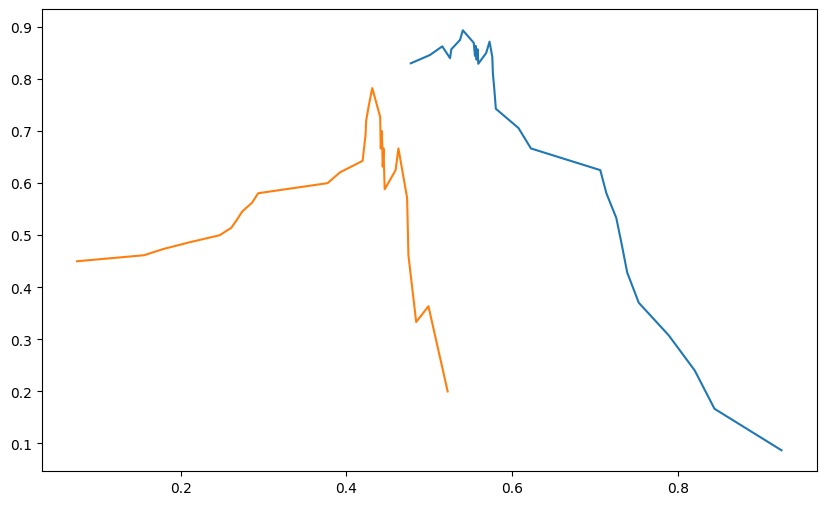

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve

# Get predictions on the test set (probabilities)
y_pred_probs = model.predict(test_generator)

# Get true labels for the test set
y_true = test_generator.classes
print(y_true)

# Define class labels
class_labels = {0: 'HDPE', 1: 'PET', 2: 'PP', 3: 'PS'}

# Create figure for plotting
plt.figure(figsize=(10, 6))

# Store macro F1 scores at common thresholds
common_thresholds = np.linspace(0.0, 1.0, 50)
macro_f1_scores = []
threshold_f1_dict = {t: [] for t in common_thresholds}

# Loop through each class to calculate F1 score at different thresholds
for class_index, class_name in class_labels.items():
    # Get probabilities for the current class
    y_probs = y_pred_probs[:, class_index]

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_true == class_index, y_probs)

    # Calculate F1 score for each threshold (avoid division by zero)
    f1_scores = np.nan_to_num(2 * (precision * recall) / (precision + recall))

    # Store class-wise F1 scores at common thresholds (interpolating where needed)
    interpolated_f1 = np.interp(common_thresholds, thresholds, f1_scores[:-1])
    for i, t in enumerate(common_thresholds):
        threshold_f1_dict[t].append(interpolated_f1[i])

    # Plot per-class F1 score curve
    plt.plot(thresholds, f1_scores[:-1], label=f"{class_name}")

# Compute Macro F1 Score at each common threshold
for t in common_thresholds:
    macro_f1_scores.append(np.mean(threshold_f1_dict[t]))

# Find the optimal threshold (maximizing macro F1)
optimal_threshold = common_thresholds[np.argmax(macro_f1_scores)]
optimal_f1 = max(macro_f1_scores)

# Plot Macro F1 Score Curve
plt.plot(common_thresholds, macro_f1_scores, 'k--', label="Macro F1 Score", linewidth=2)

# Mark the optimal threshold on the plot
plt.axvline(x=optimal_threshold, color='red', linestyle=':', label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, optimal_f1, color='red', s=100, zorder=3)

# Labels and title
plt.xlabel("Confidence Threshold", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.title("F1 Score vs. Confidence Threshold (Per Class + Macro)", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Print the optimal threshold
print(f"Optimal Confidence Threshold: {optimal_threshold:.4f} (Max Macro F1: {optimal_f1:.4f})")


# PRECISION CONFIDENCE GRAPH


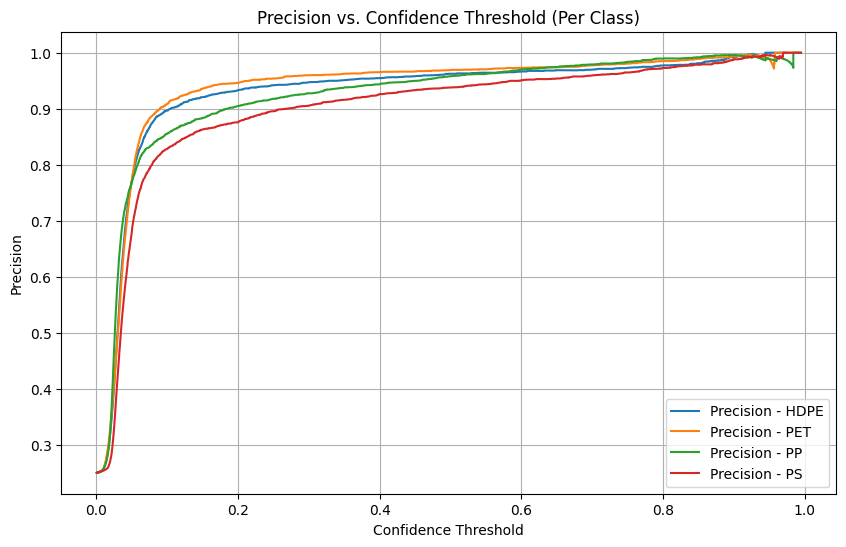

In [ ]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot Precision vs. Confidence Threshold for each class
for class_index in class_labels.keys():
    y_probs = y_pred_probs[:, class_index]
    precision, recall, class_thresholds = precision_recall_curve(y_true == class_index, y_probs)

    plt.plot(class_thresholds, precision[:-1], label=f"Precision - {class_labels[class_index]}")

plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.title("Precision vs. Confidence Threshold (Per Class)")
plt.legend()
plt.grid(True)
plt.show()


#RECALL CONFIDENCE


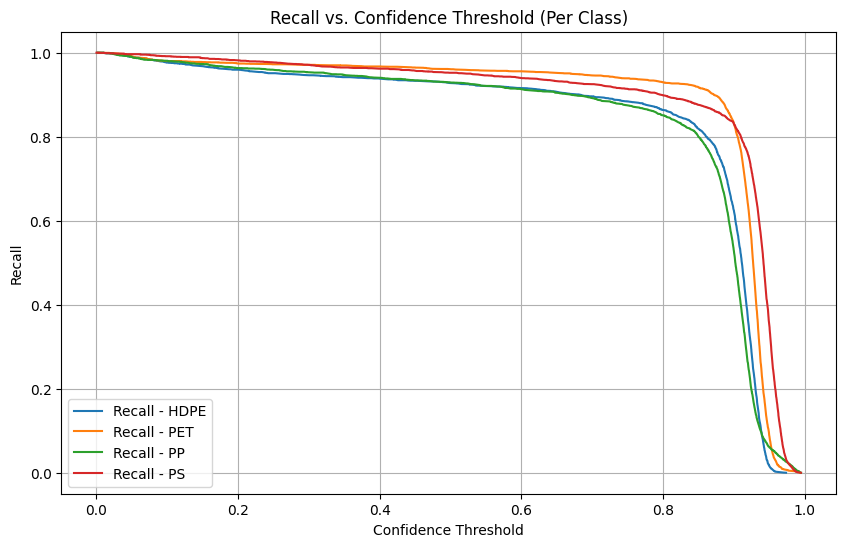

In [ ]:
# Create figure
plt.figure(figsize=(10, 6))

# Plot Recall vs. Confidence Threshold for each class
for class_index in class_labels.keys():
    y_probs = y_pred_probs[:, class_index]
    precision, recall, class_thresholds = precision_recall_curve(y_true == class_index, y_probs)

    plt.plot(class_thresholds, recall[:-1], label=f"Recall - {class_labels[class_index]}")

plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall vs. Confidence Threshold (Per Class)")
plt.legend()
plt.grid(True)
plt.show()


#PRECISION RECALL

718/718 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step


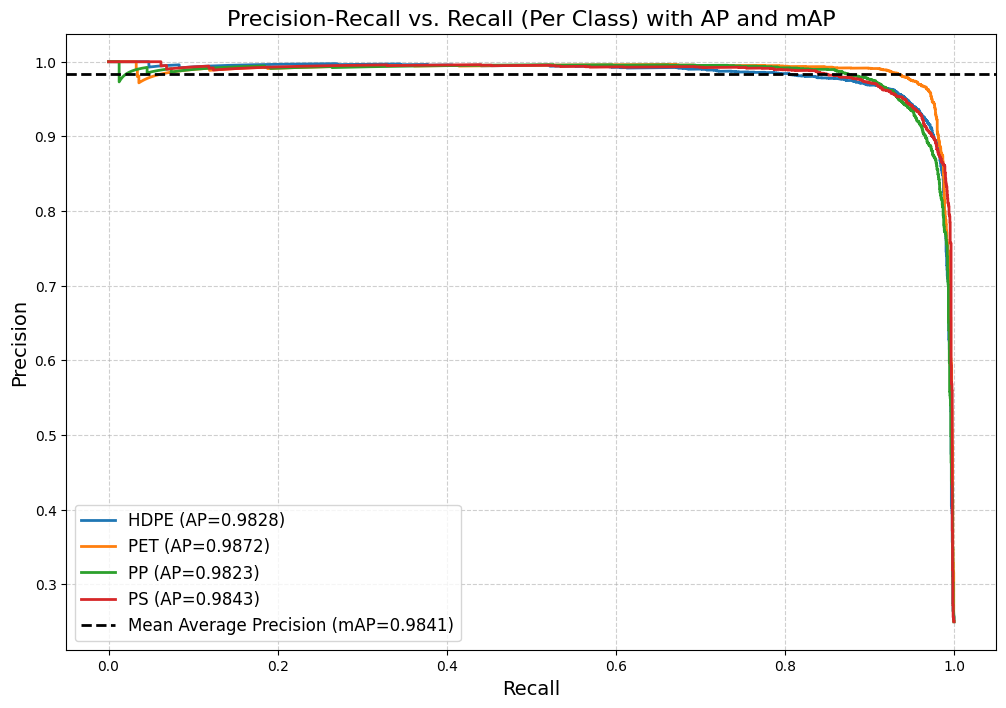

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

# Example: Get predictions (probabilities) from the model
y_pred_probs = model.predict(test_generator)  # Shape: (num_samples, num_classes)

# True labels for the test set
y_true = test_generator.classes  # Shape: (num_samples,)

# Define class labels
class_labels = {0: 'HDPE', 1: 'PET', 2: 'PP', 3: 'PS'}

# Store Average Precision (AP) for each class
average_precisions = []

# Create figure for plotting
plt.figure(figsize=(12, 8))

# Loop through each class to calculate Precision-Recall and AP at different thresholds
for class_index, class_name in class_labels.items():
    # Get probabilities for the current class
    y_probs = y_pred_probs[:, class_index]

    # Check if the class exists in `y_true`
    if np.sum(y_true == class_index) == 0:
        print(f"Skipping class {class_name} (No instances found in test set)")
        continue

    # Calculate precision, recall, and thresholds for the current class
    precision, recall, thresholds = precision_recall_curve(y_true == class_index, y_probs)

    # Calculate Average Precision (AP) for the current class
    ap = average_precision_score(y_true == class_index, y_probs)
    average_precisions.append(ap)

    # Plot per-class Precision-Recall curve with AP annotation
    plt.plot(recall, precision, label=f"{class_name} (AP={ap:.4f})", linewidth=2)

# Calculate Macro Average Precision (mAP) by averaging the APs across all classes
mAP = np.mean(average_precisions)

# Plot Macro Average Precision (mAP) as a horizontal line
plt.axhline(y=mAP, color='black', linestyle='--', linewidth=2, label=f"Mean Average Precision (mAP={mAP:.4f})")

# Plot labels, title, and legend for the plot
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall vs. Recall (Per Class) with AP and mAP", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


#PRECISION CONFIDENCE WITH ALL CLASS TOGETHER

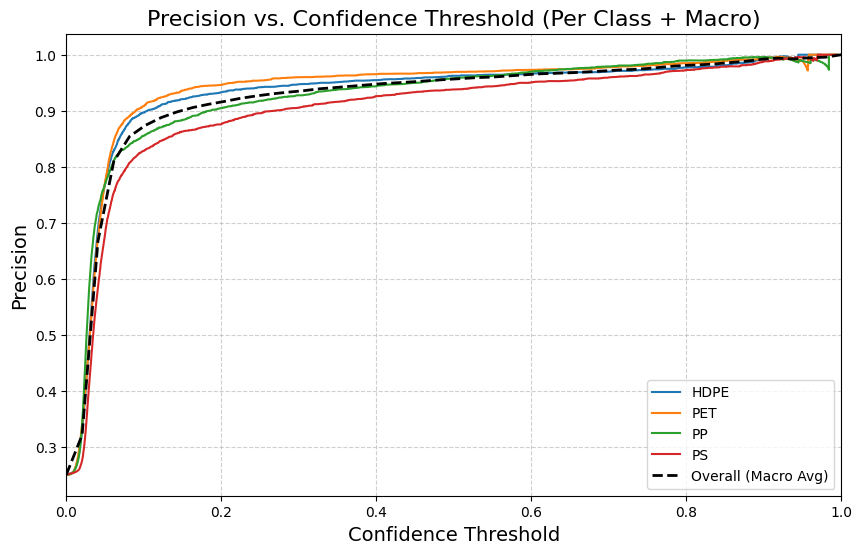

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

# Initialize lists to store per-class precision scores
class_precision_scores = {class_index: [] for class_index in class_labels.keys()}
class_thresholds = {}

# Create figure
plt.figure(figsize=(10, 6))

# Loop through classes and calculate precision for each class at different thresholds
for class_index, class_name in class_labels.items():
    y_probs = y_pred_probs[:, class_index]

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_true == class_index, y_probs)

    # Store precision and thresholds
    class_precision_scores[class_index] = precision[:-1]  # Exclude last threshold value (corresponds to precision=1)
    class_thresholds[class_index] = thresholds  # Store corresponding thresholds

    # Plot per-class precision
    plt.plot(thresholds, precision[:-1], label=f"{class_name}")

# Define common thresholds for interpolation
common_thresholds = np.linspace(0.0, 1.0, 50)
macro_precision_scores = []

# Compute Macro Precision at Each Common Threshold
for t in common_thresholds:
    precisions_at_threshold = []

    for class_index in class_labels.keys():
        # Get thresholds for this class
        thresholds = class_thresholds[class_index]

        # If `t` is lower than the minimum threshold, use the first precision value
        if t < thresholds[0]:
            precision_value = class_precision_scores[class_index][0]
        else:
            # Find closest threshold index or interpolate precision
            precision_value = np.interp(t, thresholds, class_precision_scores[class_index])

        precisions_at_threshold.append(precision_value)

    # Compute Macro Precision (average of class-wise precision at `t`)
    macro_precision = np.mean(precisions_at_threshold)
    macro_precision_scores.append(macro_precision)

# Plot the macro precision curve
plt.plot(common_thresholds, macro_precision_scores, 'k--', label="Overall (Macro Avg)", linewidth=2)

# Add labels and title
plt.xlabel("Confidence Threshold", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision vs. Confidence Threshold (Per Class + Macro)", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim([0, 1])
plt.show()


#RECALL CONFIDENCE WITH ALL CLASS TOGETHER

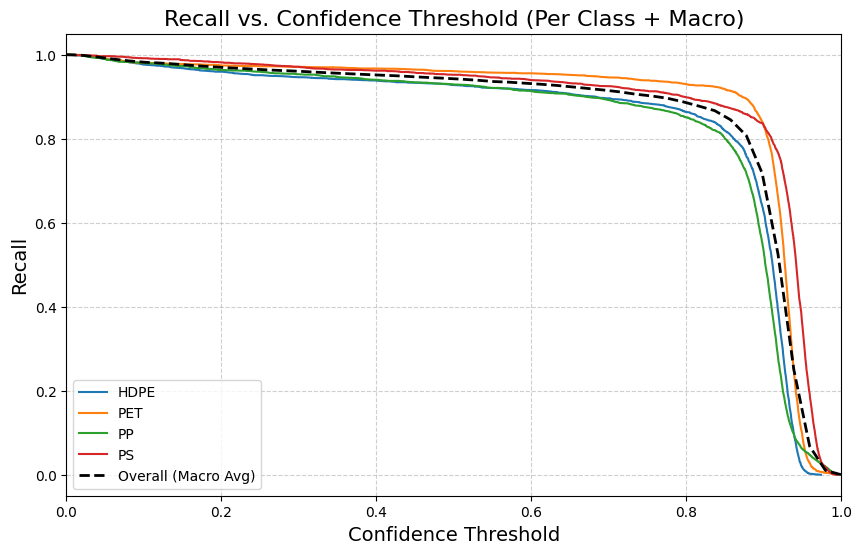

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

# Initialize lists to store per-class recall scores
class_recall_scores = {class_index: [] for class_index in class_labels.keys()}
class_thresholds = {}

# Create figure
plt.figure(figsize=(10, 6))

# Loop through classes and calculate recall for each class at different thresholds
for class_index, class_name in class_labels.items():
    y_probs = y_pred_probs[:, class_index]

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_true == class_index, y_probs)

    # Store recall and thresholds
    class_recall_scores[class_index] = recall[:-1]  # Exclude last threshold value (corresponds to recall=0)
    class_thresholds[class_index] = thresholds  # Store corresponding thresholds

    # Plot per-class recall
    plt.plot(thresholds, recall[:-1], label=f"{class_name}")

# Define common thresholds for interpolation
common_thresholds = np.linspace(0.0, 1.0, 50)
macro_recall_scores = []

# Compute Macro Recall at Each Common Threshold
for t in common_thresholds:
    recalls_at_threshold = []

    for class_index in class_labels.keys():
        # Get thresholds for this class
        thresholds = class_thresholds[class_index]

        # If `t` is lower than the minimum threshold, use the first recall value
        if t < thresholds[0]:
            recall_value = class_recall_scores[class_index][0]
        else:
            # Find closest threshold index or interpolate recall
            recall_value = np.interp(t, thresholds, class_recall_scores[class_index])

        recalls_at_threshold.append(recall_value)

    # Compute Macro Recall (average of class-wise recall at `t`)
    macro_recall = np.mean(recalls_at_threshold)
    macro_recall_scores.append(macro_recall)

# Plot the macro recall curve
plt.plot(common_thresholds, macro_recall_scores, 'k--', label="Overall (Macro Avg)", linewidth=2)

# Add labels and title
plt.xlabel("Confidence Threshold", fontsize=14)
plt.ylabel("Recall", fontsize=14)
plt.title("Recall vs. Confidence Threshold (Per Class + Macro)", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim([0, 1])
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model("plastic_classification.keras")

# Class labels
class_labels = {0: 'HDPE', 1: 'Other', 2: 'PET', 3: 'PP', 4: 'PS'}

# Path to the test image
image_path = "/content/datasets/test/HDPE/0010_a02b01c1d0e0f1g0h0_jpg.rf.e8cd4e940330308ac24656e2840a771e_box_0.jpg"

# Preprocess the image
img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make prediction
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_label = class_labels[predicted_class_index]

# Display the image with labels
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")  # actual_label needs to be obtained
plt.axis('off')
plt.show()

AttributeError: 'NoneType' object has no attribute 'build'

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def evaluate_model_metrics(model, test_generator):
    """
    Evaluates the model on the test dataset and calculates FAR, FRR, and Accuracy.

    Args:
        model: The trained Keras model.
        test_generator: The ImageDataGenerator for the test set.

    Returns:
        A dictionary containing 'far', 'frr', and 'accuracy'.
    """
    # Get true labels and predictions
    true_labels = test_generator.classes
    pred_probs = model.predict(test_generator)
    pred_labels = np.argmax(pred_probs, axis=1)

    # Calculate confusion matrix
    # Assuming class 0 is 'Forgery' (Negative) and class 1 is 'Genuine' (Positive)
    # Adjust if your class indices are different
    cm = confusion_matrix(true_labels, pred_labels)

    # Extract values from confusion matrix
    # cm[0, 0]: True Negatives (TN) - Forgery correctly predicted as Forgery
    # cm[0, 1]: False Positives (FP) - Forgery incorrectly predicted as Genuine (FAR)
    # cm[1, 0]: False Negatives (FN) - Genuine incorrectly predicted as Forgery (FRR)
    # cm[1, 1]: True Positives (TP) - Genuine correctly predicted as Genuine

    TN, FP, FN, TP = cm.ravel()

    # Calculate metrics
    FAR = FP / (FP + TN) if (FP + TN) > 0 else 0
    FRR = FN / (FN + TP) if (FN + TP) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    return {
        'far': FAR,
        'frr': FRR,
        'accuracy': accuracy
    }

# Example usage:
from tensorflow.keras.models import load_model
model = load_model('/content/WD1.keras')
metrics = evaluate_model_metrics(model, test_generator)
print(f"False Acceptance Rate (FAR): {metrics['far']:.4f}")
print(f"False Rejection Rate (FRR): {metrics['frr']:.4f}")
print(f"Accuracy: {metrics['accuracy']:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 825ms/step
False Acceptance Rate (FAR): 0.0455
False Rejection Rate (FRR): 0.5556
Accuracy: 0.8065
